In [1]:
!pip install psycopg2-binary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.5 MB/s eta 0:00:00


In [2]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

# Y is the target variable
Y = house_prices_df['saleprice']
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:53:50   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.039e+05   2.06e+04     -5.037      0.000   -1.44e+05   -6.34e+04
overallqual  2.433e+04   1244.706     19.548      0.000    2.19e+04    2.68e+04
grlivarea      43.3745      2.745     15.800      0.000      37.988      48.760
garagecars   1.407e+04   3409.600      4.126      0.000    7379.047    2.08e+04
garagearea     17.5210     11.560      1.516      0.130      -5.161      40.203
totalbsmtsf    23.4504      3.183      7.368      0.000      17.206      29.695
mszoning_FV  1.933e+04    1.5e+04      1.289      0.198   -1.01e+04    4.88e+04
mszoning_RH  7305.5078   1.72e+04      0.426      0.670   -2.63e+04     4.1e+04
mszoning_RL  2.429e+04   1.39e+04      1.747      0.081   -2983.478    5.16e+04
mszoning_RM  2864.3070   1.41e+04      0.203      0.839   -2.48e+04    3.05e+04
street_Pave -8177.6681   1.74e+04     -0.470      0.639   -4.23e+04     2.6e+04
==============================================================================
Omnibus:                      355.774   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30190.746
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                      27.895   Cond. No.                     5.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared and the adjusted R-squared of the model are 0.768 and 0.766 respectively. Hence, according to the R-squared, around 23% of the variance in the target variable is unexplained by the model. AIC and BIC scores are 27970 and 28020 respectively.

Now, let's evaluate the test set performance:

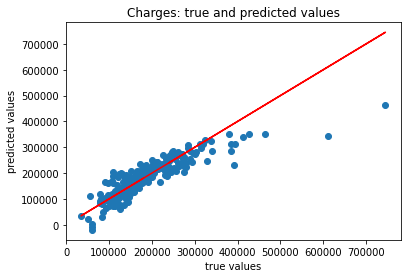

Mean absolute error of the prediction is: 25546.803828588432
Mean squared error of the prediction is: 1559083821.9730213
Root mean squared error of the prediction is: 39485.23549344769
Mean absolute percentage error of the prediction is: 15.55142034753754


In [3]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The evaluation metrics are given above. Now, let's try another model specification and compare this two models:

In [4]:
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_column_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     520.9
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:53:50   Log-Likelihood:                 463.99
No. Observations:                1168   AIC:                            -904.0
Df Residuals:                    1156   BIC:                            -843.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.9162      0.102     97.518      0.000       9.717      10.116
overallqual     0.1893      0.009     20.123      0.000       0.171       0.208
grlivarea     9.58e-05   1.89e-05      5.074      0.000    5.88e-05       0.000
garagecars      0.0779      0.015      5.244      0.000       0.049       0.107
garagearea      0.0001   5.04e-05      2.132      0.033    8.57e-06       0.000
totalsf         0.0003   2.58e-05     11.139      0.000       0.000       0.000
int_over_sf -2.572e-05   3.02e-06     -8.526      0.000   -3.16e-05   -1.98e-05
mszoning_FV     0.3911      0.065      6.055      0.000       0.264       0.518
mszoning_RH     0.2650      0.074      3.593      0.000       0.120       0.410
mszoning_RL     0.3879      0.060      6.481      0.000       0.270       0.505
mszoning_RM     0.2155      0.061      3.556      0.000       0.097       0.334
street_Pave    -0.0556      0.075     -0.744      0.457      -0.202       0.091
==============================================================================
Omnibus:                      350.711   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2714.386
Skew:                          -1.167   Prob(JB):                         0.00
Kurtosis:                      10.094   Cond. No.                     5.33e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This second model's R-squared and adjusted R-squared values are higher and AIC and BIC criterias are lower than the first model. In any case, these indicate that the second model has a better goodness of fit than the first model. Now, let's evaluate the test set performance of this second model:

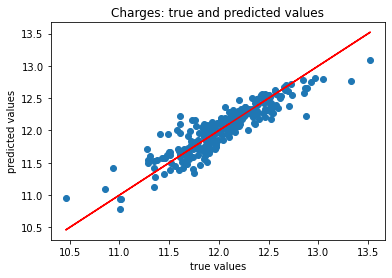

Mean absolute error of the prediction is: 0.12570372872862826
Mean squared error of the prediction is: 0.029192121871386617
Root mean squared error of the prediction is: 0.17085702172104786
Mean absolute percentage error of the prediction is: 1.050357766782366


In [5]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The test set evaluation metrics are given above. For every metric, the second model achieves a better prediction performance in the test set.